## Feature Engineering
---

#### Contents:
- [Data Loading](#Data-Loading): Load the data from the proper directory.
- [Feature Extraction](#Feature-Extraction): Create new features from the existing data.
- [Class Balancing](#Class-Balancing): Balance the classes in the dataset.
- [Test and Validation data](#Test-and-Validation-data): Prepare test and validation data as arrays.
- [Show features statistics graphically](#Show-features-statistics-graphically): Show the statistics of the features graphically.
- [Visualize the features](#Visualize-the-features): Visualize the features of the dataset to show how they are treated in extraction and their meaning.
  
#### Findings:


In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch import nn, optim
import torchaudio
import torchaudio.transforms as T
from IPython.display import Audio, display
import numpy as np
import joblib
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
from torch.utils.data import random_split
import sklearn as sk
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import sys
import random as rand
import importlib
from copy import deepcopy
#importlib.reload(utilsf)

# import all the functions
import utils as utils

In [12]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

# -------- tqdm DARK THEME --------

### Data Loading

In [13]:
EXTRACTION_INTERVALS = [1]
RANDOM_SEED = 42
IMG_SHAPE = (50, 50)
TYPE_NUM_TO_EXTRACT = {
	'mfcc': None,
	'spectrogram': None,
	'mel_spectrogram': None,
 }
PATH_TO_SAVE =  '../features/raw/' # path where to save the extracted features (e.g. raw, processed)

DATA_PATH = '../dataset/'
SAMPLE_RATE = 4000
CLASSES = ['artifacts', 'extrahls', 'murmurs', 'normals', 'extrastoles']
PATHS_FROM_EXTRACT = [f'{DATA_PATH}{CLASS}_{SAMPLE_RATE}/' for CLASS in CLASSES]

In [14]:
def extract_audio_features_images(audio_path: str, label: int, type_to_extract:dict, extraction_interval:int, image_shape: tuple = (20, 100)):
     """
     Extracts various audio features from the given audio file.

     Args:
          audio_path (str): Path to the audio file.
          label (int): The label for the extracted audio features.
          type_to_extract (dict): A dictionary specifying the types of audio features to extract.
          extraction_interval (int): The time interval (in seconds) for extracting audio features.
          image_shape (tuple, optional): The shape of the output image. Defaults to (20, 100).

     Returns:
          dict: A dictionary containing the extracted audio features.
     """
     type_to_extract_local = {key: [] for key in type_to_extract.keys()}
     
     # initialize lists used to store the extracted features
     mfcc_list, cqt_list, chroma_stft_list, rms_list, spectral_centroid_list, spectral_bandwidth_list, spectral_rolloff_list, zero_crossing_rate_list, spectrogram_list, mel_spectrogram_list = [], [], [], [], [], [], [], [], [], []

     # get the number of rows and columns for the image
     num_rows = image_shape[0]
     num_cols = image_shape[1]
     
     # load an audio file
     audio, sr = torchaudio.load(audio_path)
     audio_duration = int(audio.shape[1] / (sr * extraction_interval))
     
     for i in range(audio_duration):
          #print(i)
          audio_slice = audio[:, int(i*sr*extraction_interval):int((i+1)*sr*extraction_interval)]

          # define hop_length to have 100 columns as output
          hop_length = int(audio_slice.shape[1] / num_cols)

          if 'mfcc' in type_to_extract_local.keys():
               # extract the MFCC features
               mfcc = librosa.feature.mfcc(y=audio_slice.numpy()[0], sr=sr, n_mfcc=num_rows, hop_length=hop_length, n_fft=hop_length*2)
               mfcc = mfcc[:, :num_cols]
               mfcc_list.append(mfcc)
               type_to_extract_local['mfcc'] = mfcc_list

          if 'cqt' in type_to_extract_local.keys():
               
               try:
                    # extract the CQT features
                    cqt = np.abs(librosa.cqt(y=audio_slice.numpy()[0], sr=sr, hop_length=hop_length, n_bins=num_rows))
                    cqt = cqt[:, :num_cols]
                    cqt_list.append(cqt)
                    type_to_extract_local['cqt'] = cqt_list

               except Exception as e:
                    num_rows_ = 84
                    # make cqt have 100 rows using padding
                    cqt = np.abs(librosa.cqt(y=audio_slice.numpy()[0], sr=sr, hop_length=hop_length, n_bins=num_rows_))
                    cqt = np.pad(cqt, ((0, num_rows - num_rows_), (0, 0)), 'constant')
                    cqt = cqt[:, :num_cols]
                    cqt_list.append(cqt)
                    type_to_extract_local['cqt'] = cqt_list
                    

          if 'chroma_stft' in type_to_extract_local.keys():
               # extract the chroma_stft features
               chroma_stft = librosa.feature.chroma_stft(y=audio_slice.numpy()[0], sr=sr, hop_length=hop_length, n_chroma=num_rows, win_length=hop_length*2)
               chroma_stft = chroma_stft[:, :num_cols]
               chroma_stft_list.append(chroma_stft)
               type_to_extract_local['chroma_stft'] = chroma_stft_list

          if 'rms' in type_to_extract_local.keys():
               # extract the rms features
               rms = np.repeat(librosa.feature.rms(y=audio_slice.numpy()[0], hop_length=hop_length, frame_length=hop_length*2), num_rows, axis=0)
               rms = rms[:, :num_cols]
               rms_list.append(rms)
               type_to_extract_local['rms'] = rms_list

          if 'spectral_centroid' in type_to_extract_local.keys():
               # extract the spectral_centroid features
               spectral_centroid = np.repeat(librosa.feature.spectral_centroid(y=audio_slice.numpy()[0], sr=sr, hop_length=hop_length, n_fft=hop_length*2), num_rows, axis=0)
               spectral_centroid = spectral_centroid[:, :num_cols]
               spectral_centroid_list.append(spectral_centroid)
               type_to_extract_local['spectral_centroid'] = spectral_centroid_list

          if 'spectral_bandwidth' in type_to_extract_local.keys():
               # extract the spectral_bandwidth features
               spectral_bandwidth = np.repeat(librosa.feature.spectral_bandwidth(y=audio_slice.numpy()[0], sr=sr, hop_length=hop_length, n_fft=hop_length*2), num_rows, axis=0)
               spectral_bandwidth = spectral_bandwidth[:, :num_cols]
               spectral_bandwidth_list.append(spectral_bandwidth)
               type_to_extract_local['spectral_bandwidth'] = spectral_bandwidth_list

          if 'spectral_rolloff' in type_to_extract_local.keys():
               # extract the spectral_rolloff features
               spectral_rolloff = np.repeat(librosa.feature.spectral_rolloff(y=audio_slice.numpy()[0], sr=sr, hop_length=hop_length, n_fft=hop_length*2), num_rows, axis=0)
               spectral_rolloff = spectral_rolloff[:, :num_cols]
               spectral_rolloff_list.append(spectral_rolloff)
               type_to_extract_local['spectral_rolloff'] = spectral_rolloff_list

          if 'zero_crossing_rate' in type_to_extract_local.keys():
               # extract the zero_crossing_rate features
               zero_crossing_rate = np.repeat(librosa.feature.zero_crossing_rate(y=audio_slice.numpy()[0], hop_length=hop_length, frame_length=hop_length*2), num_rows, axis=0)
               zero_crossing_rate = zero_crossing_rate[:, :num_cols]
               zero_crossing_rate_list.append(zero_crossing_rate)
               type_to_extract_local['zero_crossing_rate'] = zero_crossing_rate_list
               
          if 'spectrogram' in type_to_extract_local.keys():
               # extract the classic spectrogram features
               stft = np.abs(librosa.stft(y=audio_slice.numpy()[0], hop_length=hop_length, n_fft=hop_length*2))
               spectrogram = librosa.amplitude_to_db(stft, ref=np.max)
               spectrogram = spectrogram[:num_rows, :num_cols]
               spectrogram_list.append(spectrogram)
               type_to_extract_local['spectrogram'] = spectrogram_list

          if 'mel_spectrogram' in type_to_extract_local.keys():
               # extract the mel spectrogram features
               mel_spectrogram = librosa.feature.melspectrogram(y=audio_slice.numpy()[0], sr=sr, n_mels=num_rows, hop_length=hop_length, n_fft=hop_length*2)
               mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
               mel_spectrogram_db = mel_spectrogram_db[:, :num_cols]
               mel_spectrogram_list.append(mel_spectrogram_db)
               type_to_extract_local['mel_spectrogram'] = mel_spectrogram_list

     # add the labels to the dictionary
     type_to_extract_local['label'] = list(np.ones(len(type_to_extract_local['mfcc'])) * label)
     
     # # convert all to tensors
     # for key in type_to_extract_local.keys():
     #      if key != 'label':
     #           type_to_extract_local[key] = torch.tensor(type_to_extract_local[key])
               
     return type_to_extract_local


def save_features(data:torch.Tensor, path:str, name:str, overwrite:bool=False):
    """
    Save the features to a file.

    Args:
        data (torch.Tensor): The data to be saved.
        path (str): The path to save the data.
        name (str): The name of the file.
        overwrite (bool, optional): Whether to overwrite the file if it already exists. Default is False.

    Returns:
        None
    """
    
    # if file already exists, ask the user if they want to overwrite it
    if os.path.exists(path + name+'.pt') and overwrite == False:
        print(f"File {path + name}.pt already exists.")
        return None
    else:
        torch.save(data, path + name+'.pt')
        print(f"Data saved to {path + name}.pt.")
        return None
    


In [15]:

# set the storing dictionary
set_storing = {'train': {'X': [], 'y': []}, 'test': {'X': [], 'y': []}}
set_storing_nosplit = {'X': [], 'y': []}
set_name = ['train', 'test']

for EXTRACTION_INTERVAL in EXTRACTION_INTERVALS:
	NAME = f'features_images_{EXTRACTION_INTERVAL}_{IMG_SHAPE}_'
	for key in TYPE_NUM_TO_EXTRACT.keys():
		NAME += f'{key}_'
	NAME = NAME[:-1]
	NAME = NAME + '.pt'

	if os.path.exists(PATH_TO_SAVE + NAME):
		print(f'The features for the interval {EXTRACTION_INTERVAL} already exist.')
		continue

	print(f'\nExtracting features for the interval {EXTRACTION_INTERVAL}\n')
	storing_dict = {key: deepcopy(set_storing) for key in TYPE_NUM_TO_EXTRACT}
	storing_dict_nosplit = {key: deepcopy(set_storing_nosplit) for key in TYPE_NUM_TO_EXTRACT}

	# extract the features for the real audio files
	for label, path in enumerate(PATHS_FROM_EXTRACT):
			print(f'Extracting features for the real audio files from {path}')
			for j, file in tqdm(enumerate(os.listdir(path)), total=len(os.listdir(path))):
				audio_path = path + file
				#print(f' -------- {audio_path} --------')
				audio_features = extract_audio_features_images(audio_path, label=label, type_to_extract=TYPE_NUM_TO_EXTRACT, extraction_interval=EXTRACTION_INTERVAL, image_shape=IMG_SHAPE)
				
				for key in audio_features.keys():
					if key != 'label':
						storing_dict_nosplit[key]['X'].extend(audio_features[key])
						storing_dict_nosplit[key]['y'].extend(audio_features['label'])

	# split the data into train and test sets
	for key in storing_dict_nosplit.keys():
		X_train, X_test, y_train, y_test = train_test_split(storing_dict_nosplit[key]['X'], storing_dict_nosplit[key]['y'], test_size=0.2, random_state=RANDOM_SEED)
		storing_dict[key]['train']['X'] = torch.tensor(X_train)
		storing_dict[key]['train']['y'] = torch.tensor(y_train)
		storing_dict[key]['test']['X'] = torch.tensor(X_test)
		storing_dict[key]['test']['y'] = torch.tensor(y_test)

	# save the entire dictionary
	save_features(storing_dict, PATH_TO_SAVE, NAME[:-3], overwrite=True)


Extracting features for the interval 1

Extracting features for the real audio files from ../dataset/artifacts_4000/


  0%|          | 0/84 [00:00<?, ?it/s]

Extracting features for the real audio files from ../dataset/extrahls_4000/


  0%|          | 0/19 [00:00<?, ?it/s]

Extracting features for the real audio files from ../dataset/murmurs_4000/


  0%|          | 0/149 [00:00<?, ?it/s]

Extracting features for the real audio files from ../dataset/normals_4000/


  0%|          | 0/355 [00:00<?, ?it/s]

Extracting features for the real audio files from ../dataset/extrastoles_4000/


  0%|          | 0/46 [00:00<?, ?it/s]

Data saved to ../features/raw/features_images_1_(50, 50)_mfcc_spectrogram_mel_spectrogram.pt.


In [16]:
# LOAD THE DATA AND CHECK THE SHAPES
# load the features
features = torch.load(PATH_TO_SAVE + NAME)
# check the shapes
for key in features.keys():
	for set_ in features[key].keys():
		print(f'{key} - {set_} - {features[key][set_]["X"].shape}')


mfcc - train - torch.Size([3904, 50, 50])
mfcc - test - torch.Size([976, 50, 50])
spectrogram - train - torch.Size([3904, 50, 50])
spectrogram - test - torch.Size([976, 50, 50])
mel_spectrogram - train - torch.Size([3904, 50, 50])
mel_spectrogram - test - torch.Size([976, 50, 50])


### Show features statistics graphically

Train Features statistics for the last extracted file: features_images_1_(50, 50)_mfcc_spectrogram_mel_spectrogram.pt


Text(0.5, 1.0, 'Min values of mfcc train')

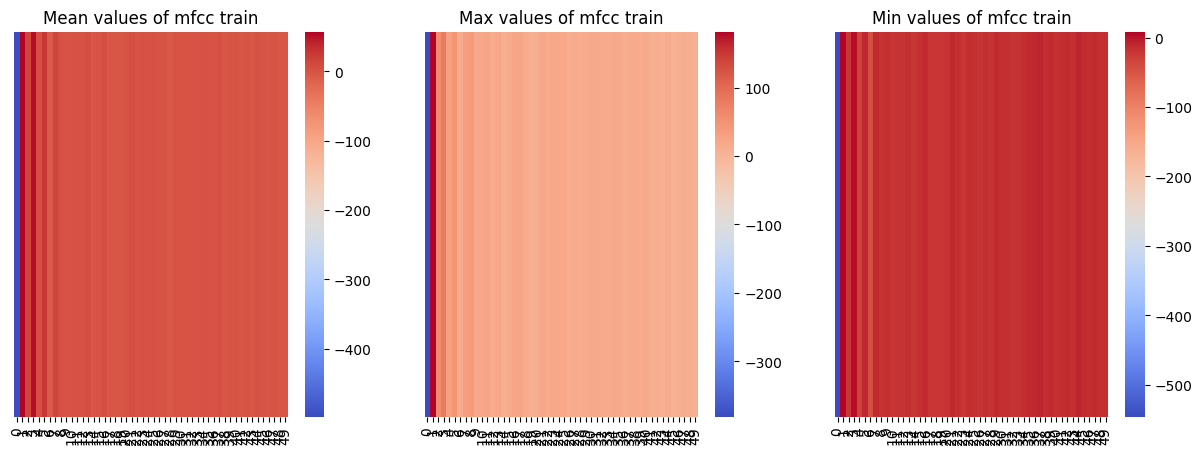

In [17]:
# shows features for the last extracted file
print(f'Train Features statistics for the last extracted file: {NAME}')

feature_type_to_represent = 'mfcc'

train=features[feature_type_to_represent]['train']['X'][0].numpy()
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# get mean values for each feature
mean_values = np.mean(train, axis=1)
sns.heatmap(mean_values.reshape(1,-1), cmap='coolwarm', cbar=True, xticklabels=True, yticklabels=False, ax=axs[0])
axs[0].set_title(f'Mean values of {feature_type_to_represent} train')

# max values
max_values = np.max(train, axis=1)
sns.heatmap(max_values.reshape(1,-1), cmap='coolwarm', cbar=True, xticklabels=True, yticklabels=False, ax=axs[1])
axs[1].set_title(f'Max values of {feature_type_to_represent} train')

# min values
min_values = np.min(train, axis=1)
sns.heatmap(min_values.reshape(1,-1), cmap='coolwarm', cbar=True, xticklabels=True, yticklabels=False, ax=axs[2])
axs[2].set_title(f'Min values of {feature_type_to_represent} train')

### Visualize the features

- MFCC, CQT and CHROMA represent more than one value for each window of the file. They are then averaged through the time axis. For example, if I choose to get 20 MFCCs and I have 100 windows, I will have a matrix of shape (100, 20). I will then average the 20 values across windows to get a single tensor of shape (1, 20).
**These kind of features have no temporal information.**

- Spectral features like Spectral Centroid, Spectral Bandwidth, Spectral Rolloff, and Zero Crossing Rate are single values for each window of the file. Thus they are not averaged, instead they are concatenated to the feature tensor. 
**These kind of features have temporal information.**

Text(0.5, 1.0, 'MEL SPECTROGRAM of the first audio file')

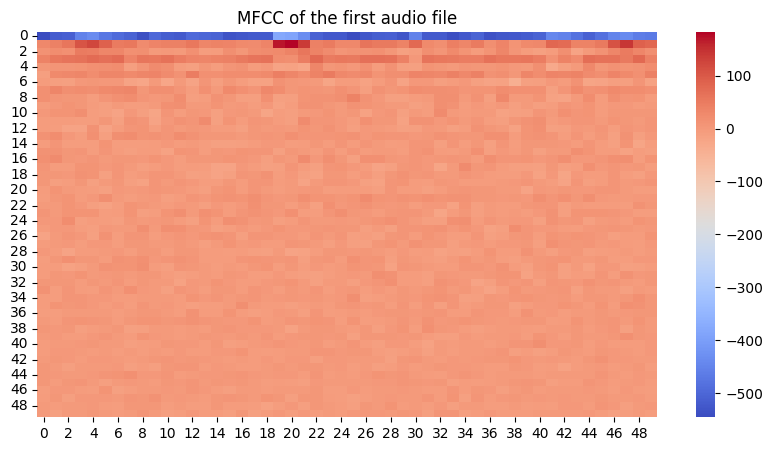

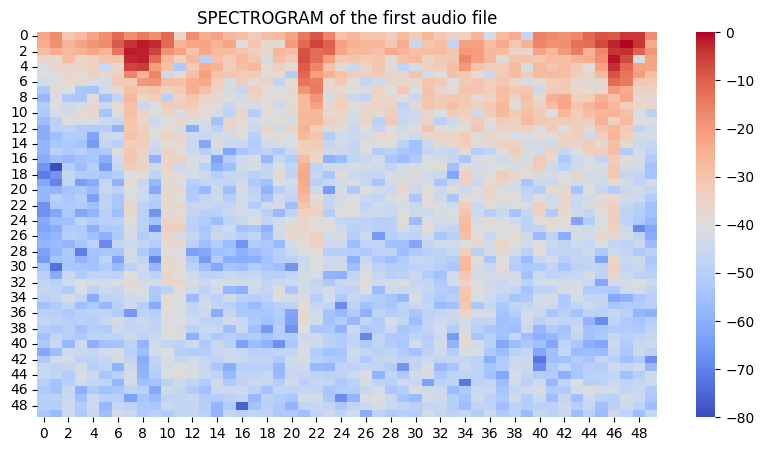

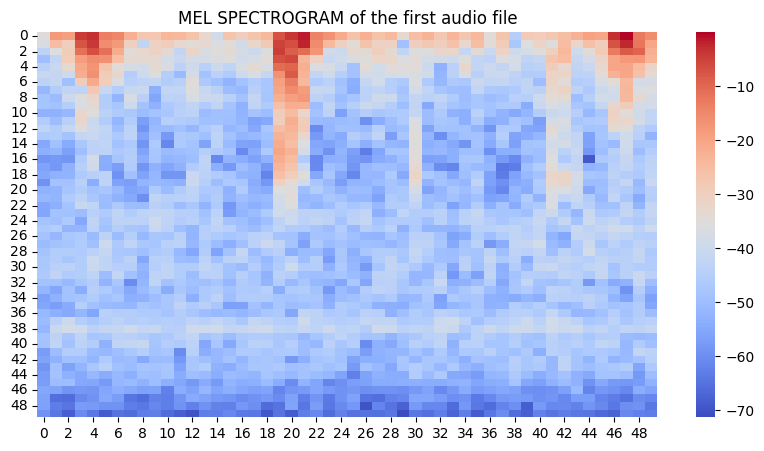

In [18]:
# load the features
features = torch.load(PATH_TO_SAVE + NAME)

# compute the mfcc
mfcc = features['mfcc']['train']['X']

# plot the mfcc
plt.figure(figsize=(10, 5))
sns.heatmap(mfcc[0].detach().numpy(), cmap='coolwarm', cbar=True)
plt.title('MFCC of the first audio file')

# compute spectrogram
cqt = features['spectrogram']['train']['X'][1000].numpy()

# plot spectrogram
plt.figure(figsize=(10, 5))
sns.heatmap(cqt, cmap='coolwarm', cbar=True)
plt.title('SPECTROGRAM of the first audio file')

# compute mel spectrogram
chroma_stft = features['mel_spectrogram']['train']['X'][0].numpy()

# plot mel spectrogram
plt.figure(figsize=(10, 5))
sns.heatmap(chroma_stft, cmap='coolwarm', cbar=True)
plt.title('MEL SPECTROGRAM of the first audio file')

In [19]:
# investigate the shapes of the extracted features
print('MFCC shape:', mfcc[0].numpy().shape)
print('Spectrogram shape:', cqt.shape)
print('Mel Spectrogram shape:', chroma_stft.shape)

MFCC shape: (50, 50)
Spectrogram shape: (50, 50)
Mel Spectrogram shape: (50, 50)
